In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.metadata.tables.keys()

dict_keys(['measurement', 'station'])

In [8]:
Inspector = inspect(engine)
for table in Inspector.get_table_names():
    print("*"*24)
    print(table)
    print("-"*24)
    for column in Inspector.get_columns(table):
        if(len(column["name"])<=6):
            print(column["name"],"\t\t",column["type"])
        else:
            print(column["name"],"\t",column["type"])

************************
measurement
------------------------
id 		 INTEGER
station 	 TEXT
date 		 TEXT
prcp 		 FLOAT
tobs 		 FLOAT
************************
station
------------------------
id 		 INTEGER
station 	 TEXT
name 		 TEXT
latitude 	 FLOAT
longitude 	 FLOAT
elevation 	 FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= :date_1


<AxesSubplot:xlabel='date'>

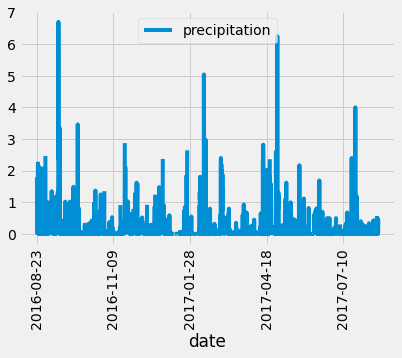

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# max date in database is 2017-08-23
max_date = session.query(func.max(Measurement.date)).first()[0]
# Calculate the date 1 year ago from the last data point in the database
today = dt.date(2017,8,23)
last_year = today - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
#stations = session.query(Station.station, Station.name)
#df_station = pd.read_sql(stations.statement, engine)

prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year)

#prcp = session.query(Measurement.date, Measurement.prcp).\
#    filter(Measurement.date < today).filter(Measurement.date >= last_year).\
#    filter(Measurement.station == "USC00516128")

# Save the query results as a Pandas DataFrame and set the index to the date column
print(prcp.statement)
df = pd.read_sql(prcp.statement, engine)
df.columns = ["date", "precipitation"]
# Sort the dataframe by date
df = df.sort_values(by=["date"])
df = df.set_index("date")
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_stat = df.groupby(df.index)["precipitation"].agg(["sum", "min", "max", "mean"])
df_stat

,sum,min,max,mean
date,,,,
2016-08-23,2.71,0.00,1.79,0.451667
2016-08-24,9.33,0.08,2.28,1.555000
2016-08-25,0.54,0.00,0.21,0.077143
2016-08-26,0.10,0.00,0.04,0.016667
2016-08-27,0.32,0.00,0.18,0.064000
...,...,...,...,...
2017-08-19,0.09,0.00,0.09,0.030000
2017-08-20,0.01,0.00,0.01,0.005000
2017-08-21,0.58,0.00,0.56,0.193333


In [13]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
stations_count

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Station.id, Station.station, Station.name, func.count(1)).filter(Station.station == Measurement.station).\
    group_by(Station.id, Station.station, Station.name).order_by(func.count(1).desc())
df_stations = pd.read_sql(stations.statement, engine)
df_stations.columns = ["id", "station", "name", "count"]
df_stations

,id,station,name,count
0,7,USC00519281,"WAIHEE 837.5, HI US",2772
1,1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,2,USC00513117,"KANEOHE 838.1, HI US",2709
3,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,4,USC00517948,"PEARL CITY, HI US",1372
8,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [15]:
most_active_id = 7
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature = session.query(Station.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Station.station == Measurement.station).filter(Station.id == most_active_id)
df_temperature = pd.read_sql(temperature.statement, engine)
df_temperature.columns = ["station", "min_temp", "max_temp", "avg_temp"]
df_temperature

,station,min_temp,max_temp,avg_temp
0,USC00519281,54.0,85.0,71.663781


USC00519281


<AxesSubplot:ylabel='Frequency'>

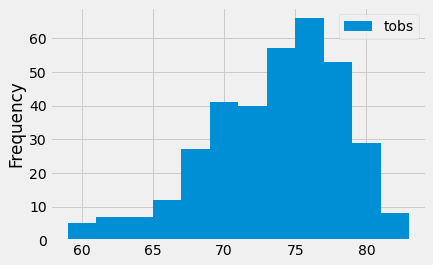

In [16]:
max_tob_count = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
print(max_tob_count[0])
temp_7 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == max_tob_count[0]).\
    filter(Measurement.date >= last_year)
df_temp_7 = pd.read_sql(temp_7.statement, engine)
df_temp_7.set_index("date",inplace=True)
df_temp_7.sort_index()
df_temp_7.plot.hist(by=["tobs"],bins=12)

## Bonus Challenge Assignment

# Temperature Analysis I

In [50]:
from scipy import stats
from numpy import mean

In [42]:
temp_jun = session.query(Measurement.tobs).filter(func.substr(Measurement.date,6,2) == "06")
temp_dec = session.query(Measurement.tobs).filter(func.substr(Measurement.date,6,2) == "12")

In [44]:
print(temp_jun.count())
print(temp_dec.count())

1700
1517


In [45]:
temp_list_jun = []
temp_list_dec = []
for x in temp_jun:
    if type(x.tobs) == float:
        temp_list_jun.append(x.tobs)
for x in temp_dec:
    if type(x.tobs) == float:
        temp_list_dec.append(x.tobs)


In [48]:
print(len(temp_list_jun))
print(len(temp_list_dec))

1700
1517


In [51]:
mean_jun = mean(temp_list_jun)
mean_dec = mean(temp_list_dec)
print(mean_jun)
print(mean_dec)

74.94411764705882
71.04152933421226


In [52]:
# Unpaired (independent) t-test
stats.ttest_ind(temp_list_jun, temp_list_dec)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

# The t-test shows that there is no significant difference between Jun mean and Dec mean. We use unpair t-test because the groups of temperature are independent.

# Temperature Analysis II

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).first()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [87]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# trip date 2018-01-16 to 2018-01-23
start_date = dt.date(2017,1,16)
end_date = dt.date(2017,1,23)
(tmin, tmax, tavg)=calc_temps("2017-01-16", "2017-01-23")

([], [])

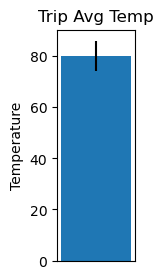

In [86]:
#style.use('default')
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ind = np.arange(2)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

height = [tavg]
plt.figure(figsize=(1,3))
plt.bar([1], height, width, yerr=(tmax-tmin), )
plt.title('Trip Avg Temp')
plt.ylabel("Temperature")
plt.xlabel("")
plt.xticks([])

In [88]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfalls = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label("Total")).\
    filter(Station.station == Measurement.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp)).all()
rainfalls


[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.02),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.15),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.15000000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.72)]

In [97]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [104]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
daily_normals_dict = {}
current_date = start_date
while current_date <= end_date:
    sdate = current_date.strftime("%m-%d")
    daily_normals_dict[(current_date+dt.timedelta(days=365)).strftime("%Y-%m-%d")] = daily_normals(sdate)[0]
    current_date = current_date + dt.timedelta(days=1)
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_dict

{'2018-01-16': (54.0, 68.62962962962963, 80.0),
 '2018-01-17': (61.0, 69.07407407407408, 76.0),
 '2018-01-18': (57.0, 68.63157894736842, 77.0),
 '2018-01-19': (60.0, 68.26315789473684, 78.0),
 '2018-01-20': (61.0, 68.86666666666666, 78.0),
 '2018-01-21': (61.0, 70.14545454545454, 76.0),
 '2018-01-22': (60.0, 69.26415094339623, 76.0),
 '2018-01-23': (57.0, 69.50909090909092, 79.0)}

In [109]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(daily_normals_dict)
df_normals = df_normals.transpose()
df_normals.columns = ["tmin", "tmax", "tavg"]
df_normals

,tmin,tmax,tavg
2018-01-16,54.0,68.629630,80.0
2018-01-17,61.0,69.074074,76.0
2018-01-18,57.0,68.631579,77.0
2018-01-19,60.0,68.263158,78.0
2018-01-20,61.0,68.866667,78.0
2018-01-21,61.0,70.145455,76.0
2018-01-22,60.0,69.264151,76.0
2018-01-23,57.0,69.509091,79.0


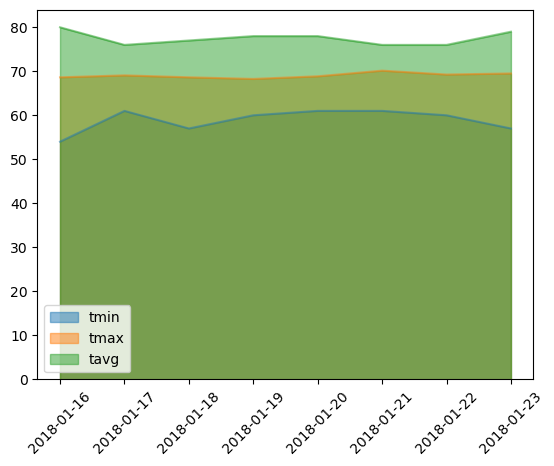

In [113]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df_normals.plot.area(rot=45, stacked=False)